In [1]:
url = 'http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/meteohydro/hydrodynamics/adcp/adcp-f.nc'

In [2]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ds = netCDF4.Dataset(url)

ds.variables.keys()

odict_keys(['x', 'y', 'time', 'Z', 'east_velocity', 'north_velocity', 'velocity', 'velocity_direction', 'error_velocity', 'crs', 'lat', 'lon', 'number_of_depths', 'waterdepth'])

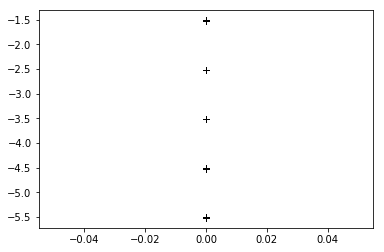

In [4]:
z = np.ma.masked_equal(ds.variables['Z'][500:1000,:, :, :], 9.96920997e+36).squeeze()
x = np.zeros_like(z)
plt.plot(x, z, 'k+');

In [5]:
U = np.squeeze(np.ma.masked_equal(ds.variables['north_velocity'][:], 9.96920997e+36).astype('double'))
V = np.squeeze(np.ma.masked_equal(ds.variables['east_velocity'][:], 9.96920997e+36).astype('double'))
time = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)
angle = np.arctan2(V, U)
Z = np.squeeze(np.ma.masked_equal(ds.variables['Z'][:], 9.96920997e+36).astype('double'))
mag = np.ma.sqrt(U**2 + V**2)

T = np.repeat(ds.variables['time'][:][:, np.newaxis], len(ds.dimensions['bins']), axis=1)

In [6]:
import scipy.interpolate
import cmocean.cm
import matplotlib.colors
import skimage.color

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


(1, 4) float64 1.0


Text(0,0.5,'depth [m]')

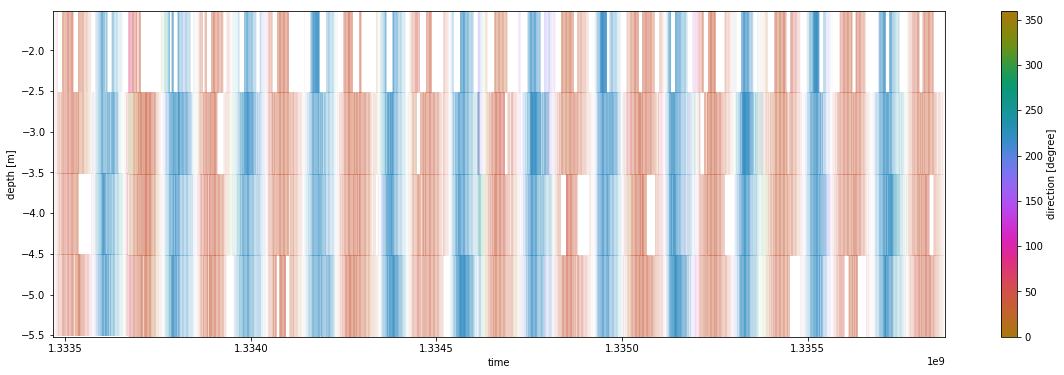

In [32]:
s = np.s_[0:8000]

N_pi = matplotlib.colors.Normalize(-np.pi, np.pi)
N_mag = matplotlib.colors.Normalize(0, 2, clip=True)
angle_color = cmocean.cm.phase(N_pi(angle[s]))
# angle_lab = skimage.color.rgb2lab(angle_color[:, :, :3])
angle_color[:, :, 3] = N_mag(mag[s])
angle_color[:, :, 3][mag[s].mask] = 0

fig,ax = plt.subplots(figsize=(20, 6))
pc = ax.pcolor(T[s], Z[s], np.rad2deg(angle[s]), vmin=0, vmax=360, cmap=cmocean.cm.phase)
plt.colorbar(pc, ax=ax, label='direction [degree]')
print(pc.get_facecolors().shape, pc.get_facecolors().dtype, pc.get_facecolors().max())
pc.set_array(None)
C = angle_color.reshape((np.prod(angle_color.shape[:2]), angle_color.shape[2]))
pc.set_facecolors(C)
ax.set_xlabel('time')
ax.set_ylabel('depth [m]')


In [15]:
ds.variables['lat'][:], ds.variables['lon'][:]

(array([[ 52.08046722]], dtype=float32), array([[ 4.21766376]], dtype=float32))

In [39]:
np.squeeze(ds.variables['Z'])


(196782, 16)

In [40]:
import scipy.interpolate

In [137]:
z_new = np.linspace(Z.min(), Z.max(), num=100)
interps = []
N = mag.shape[0]
for i in range(N):
    values = np.c_[mag[i].filled(np.nan), U[i].filled(np.nan), V[i].filled(np.nan)]
    f = scipy.interpolate.interp1d(Z[i], values.T, bounds_error=False)
    interps.append(f(z_new).T)

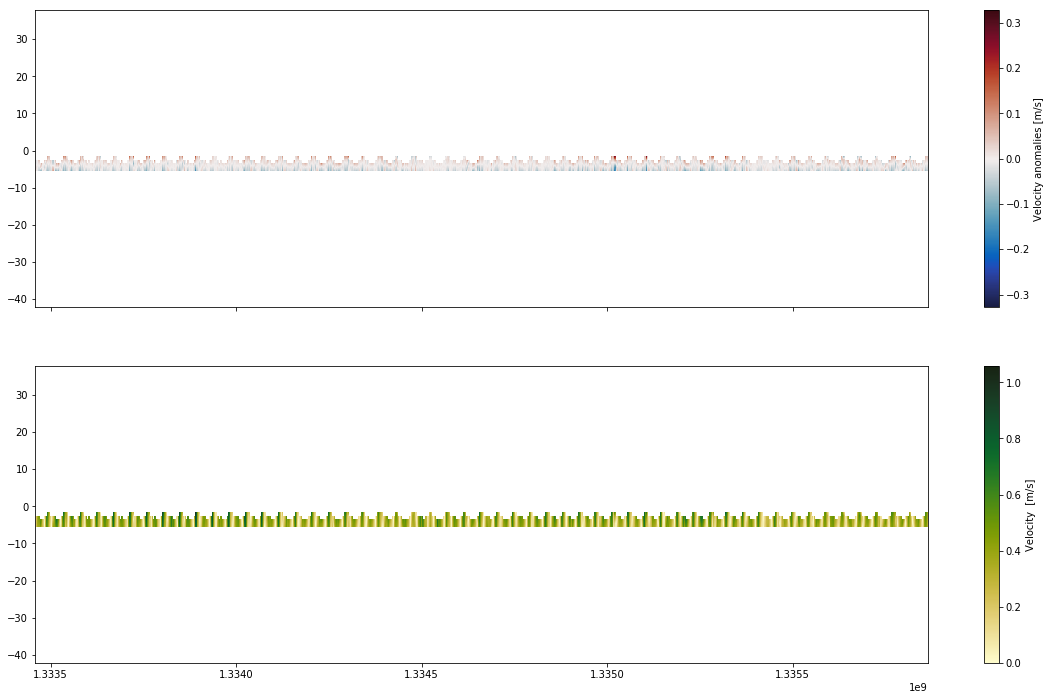

In [136]:
Mag = np.ma.masked_invalid(interps)[:, :, 0].T
Mag_anomaly = Mag - Mag.mean(axis=0)
vmax = np.ma.abs(Mag_anomaly).max()
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
im = axes[0].imshow(
    Mag_anomaly, 
    origin='top', 
    aspect=10000, 
    extent=(
        time[0].timestamp(), time[N].timestamp(), 
        z_new[0], z_new[-1]
    ),
    vmin=-vmax,
    vmax=vmax,
    cmap=cmocean.cm.balance
)
plt.colorbar(im, ax=axes[0], label='Velocity anomalies [m/s]')
im = axes[1].imshow(
    Mag, 
    origin='top', 
    aspect=10000, 
    extent=(
        time[0].timestamp(), time[N].timestamp(), 
        z_new[0], z_new[-1]
    ),
    vmin=0,
    vmax=Mag.max(),
    cmap=cmocean.cm.speed
)
plt.colorbar(im, ax=axes[1], label='Velocity  [m/s]')


In [143]:
mag_interp = np.ma.masked_invalid(interps)[:, :, 0].T
mag_interp_anomaly = mag_interp - mag_interp.mean(axis=0)
U_interp = np.ma.masked_invalid(interps)[:, :, 1].T
V_interp = np.ma.masked_invalid(interps)[:, :, 2].T


In [155]:
uvmax = np.ma.abs([U_interp.min(), U_interp.max(), V_interp.min(), V_interp.max()]).max()
mag_anomaly_max = np.ma.abs(mag_interp_anomaly).max()

In [174]:
plt.imsave('mag.png', mag_interp, cmap=cmocean.cm.speed, vmin=0, origin='lower')
plt.imsave('mag_anomaly.png', mag_interp_anomaly, cmap=cmocean.cm.balance, vmin=-0.8*mag_anomaly_max, vmax=0.8*mag_anomaly_max, origin='lower')
plt.imsave('uv.png', np.ma.arctan2(V_interp, U_interp), cmap=cmocean.cm.phase, vmin=-np.pi, vmax=np.pi, origin='lower')

In [176]:
time[0], time[-1]

(datetime.datetime(2012, 4, 3, 15, 5, 34),
 datetime.datetime(2014, 11, 19, 12, 36, 4))

array([ True, False], dtype=bool)